# На что способна YOLO.

В данном ноутбуке использованы материалы из статьи Степана Бурмистрова **"Работа с YOLOV8. Детекция, сегментация, трекинг объектов, а также подготовка собственного датасета и обучение"** (https://habr.com/ru/articles/821971/)

In [ ]:
# Для установки YOLO в наш ноутбук выполните:
!pip install ultralytics

In [2]:
from ultralytics import YOLO
import gdown
import cv2
import numpy as np
import os

In [4]:
from google.colab.patches import cv2_imshow

In [ ]:
# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')

# Кроме минимальной yolov8n.pt, доступны еще несколько: yolov8n.pt yolov8s.pt yolov8m.pt yolov8l.pt yolov8x.pt
# Каждая следующая больше, работает медленнее, но некоторые объекты определяет значительно лучше.

## Детекция объектов на фото

Детекция объектов - определение местоположения объектов и их классов на изображении.

Для примера возьмем картинку и определим объекты на ней:

Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1aJB4vFgyQIYz0hhQfy6AQkrX3VVWUKdS
To: /content/image1.png
100%|██████████| 1.59M/1.59M [00:00<00:00, 165MB/s]


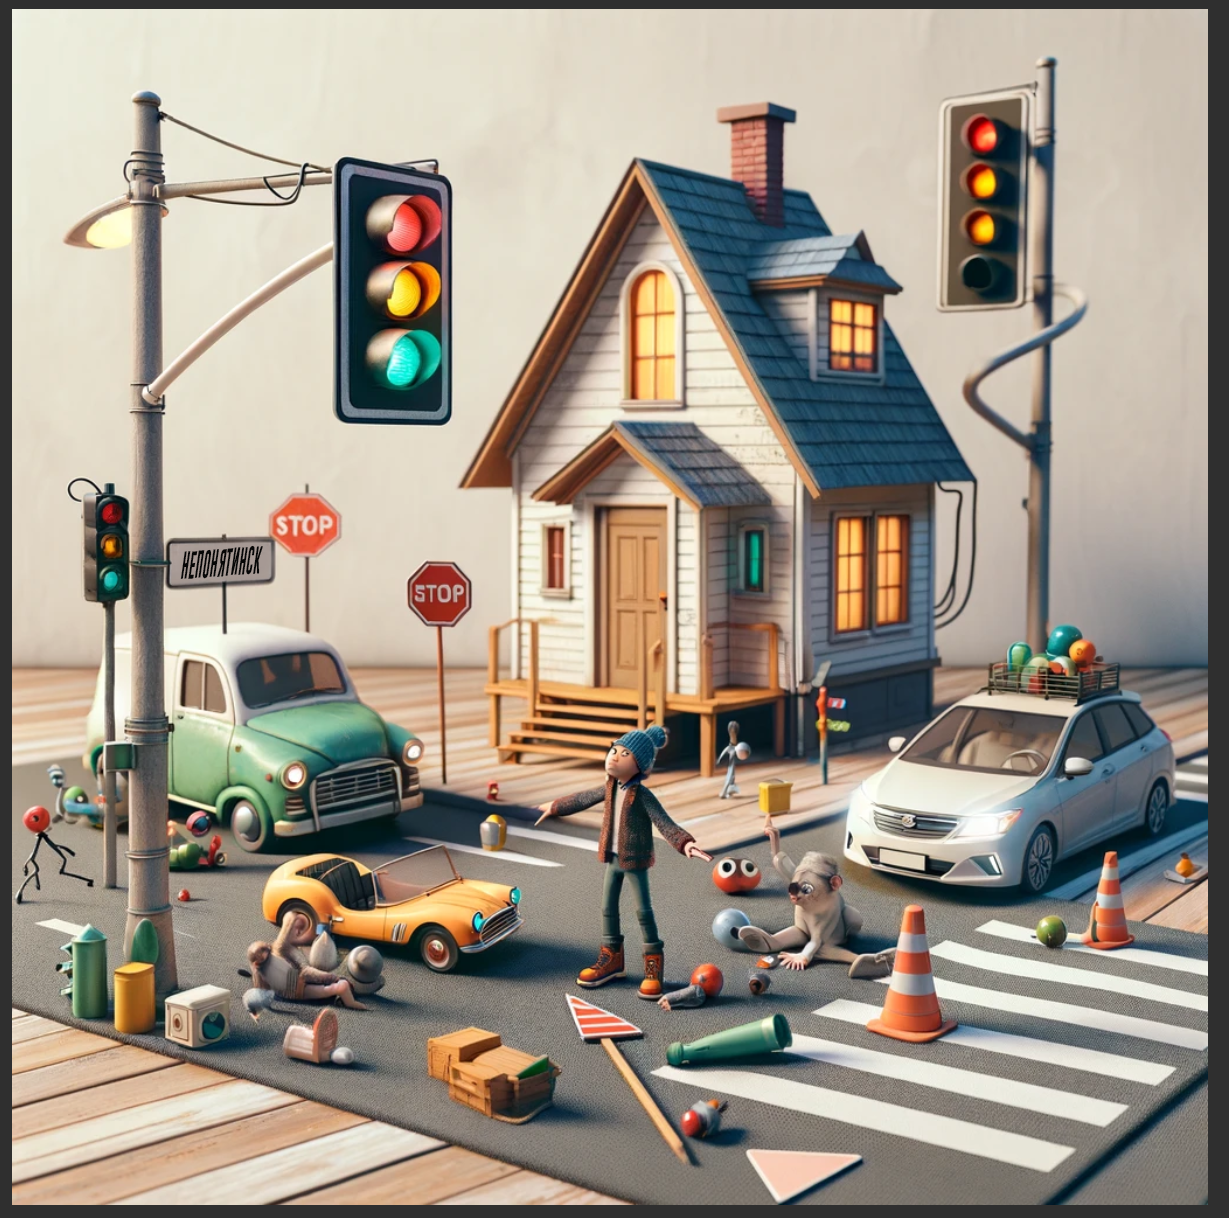

In [ ]:
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1aJB4vFgyQIYz0hhQfy6AQkrX3VVWUKdS'
image_name = 'image1.png'
gdown.download(url, image_name)
path = '/content/' + image_name
image = cv2.imread(path)
cv2_imshow(image)

In [ ]:
# Определим список цветов для различных классов
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

In [ ]:
# Функция для обработки изображения
def process_image(image_name):
    # Загрузка изображения
    path = '/content/' + image_name
    image = cv2.imread(path)
    results = model(image)[0]

    # Получение оригинального изображения и результатов
    image = results.orig_img
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)

    # Подготовка словаря для группировки результатов по классам
    grouped_objects = {}

    # Рисование рамок и группировка результатов
    for class_id, box in zip(classes, boxes):
        class_name = classes_names[int(class_id)]
        color = colors[int(class_id) % len(colors)]  # Выбор цвета для класса
        if class_name not in grouped_objects:
            grouped_objects[class_name] = []
        grouped_objects[class_name].append(box)

        # Рисование рамок на изображении
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Сохранение измененного изображения
    new_image_path = os.path.splitext(path)[0] + '_yolo' + os.path.splitext(path)[1]
    cv2.imwrite(new_image_path, image)

    # Сохранение данных в текстовый файл
    text_file_path = os.path.splitext(path)[0] + '_data.txt'
    with open(text_file_path, 'w') as f:
        for class_name, details in grouped_objects.items():
            f.write(f"{class_name}:\n")
            for detail in details:
                f.write(f"Coordinates: ({detail[0]}, {detail[1]}, {detail[2]}, {detail[3]})\n")

    print(f"Processed {path}:")
    print(f"Saved bounding-box image to {new_image_path}")
    print(f"Saved data to {text_file_path}")

In [ ]:
process_image('image1.png')

**После выполнения функции process_image видим результат:**

In [ ]:
image = cv2.imread('/content/image1_yolo.png')
cv2_imshow(image)

# Детекция объектов в видео-потоке

После практики с одним изображением перейдем к обработке видео. В целом, оно не сильно сложнее, т.к. видео это всего лишь последовательность изображений!

In [ ]:
# Список цветов для различных классов
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

In [ ]:
# Открытие исходного видеофайла
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1YVdLlJHJKXO0IvWsWg0kqpnFTZbLwrzE'
video_name = 'video1.mp4'
gdown.download(url, video_name)
input_video_path = '/content/' + video_name
capture = cv2.VideoCapture(input_video_path)

# Чтение параметров видео
fps = int(capture.get(cv2.CAP_PROP_FPS))
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Настройка выходного файла
output_video_path = '/content/detect.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while True:
    # Захват кадра
    ret, frame = capture.read()
    if not ret:
        break

    # Обработка кадра с помощью модели YOLO
    results = model(frame)[0]

    # Получение данных об объектах
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)
    # Рисование рамок и подписей на кадре
    for class_id, box, conf in zip(classes, boxes, results.boxes.conf):
        if conf>0.5:
            class_name = classes_names[int(class_id)]
            color = colors[int(class_id) % len(colors)]
            x1, y1, x2, y2 = box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Запись обработанного кадра в выходной файл
    writer.write(frame)

# Освобождение ресурсов и закрытие окон
capture.release()
writer.release()

Скачайте полученный видеофайл **detect.mp4** к себе на компьютер и посмотрите, что получилось

# Сегментация изображения

Сегментация - разделение изображения на классы. Для начала возьмем вот такую фотографию и снова применим модель YOLOv8

Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1TruozegFVlXJ3ClQ-UnZlMV2VSIEZDIp
To: /content/image2.jpg
100%|██████████| 257k/257k [00:00<00:00, 77.5MB/s]


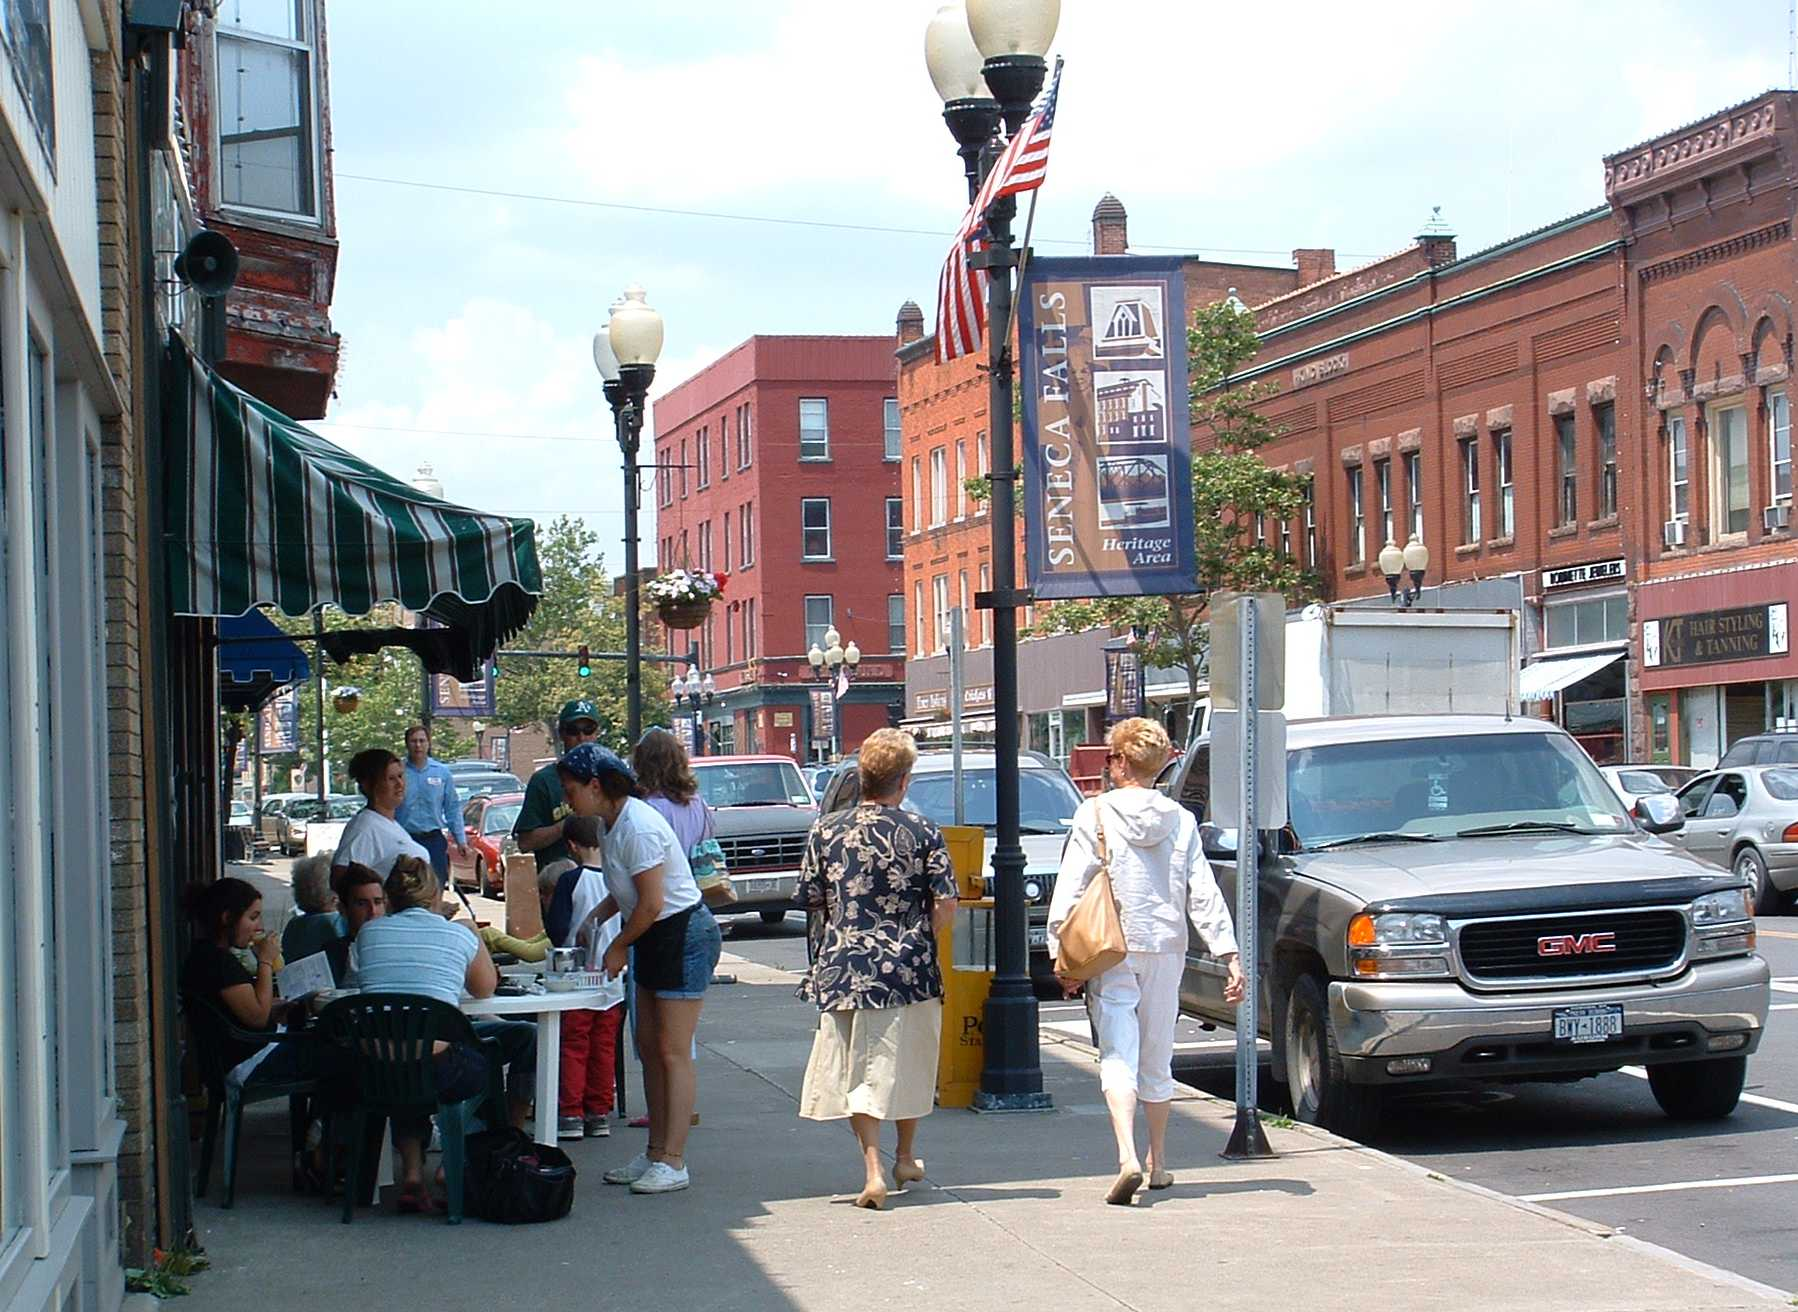

In [ ]:
# Исходное фото:
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1TruozegFVlXJ3ClQ-UnZlMV2VSIEZDIp'
image_name = 'image2.jpg'
gdown.download(url, image_name)
path = '/content/' + image_name
image = cv2.imread(path)
cv2_imshow(image)

In [ ]:
# Загрузка модели YOLOv8 (специальный вариант для сегментции)
model = YOLO('yolov8x-seg.pt')

In [ ]:
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

In [ ]:
def process_image(image_path):
    # Проверка наличия папки для сохранения результатов
    if not os.path.exists('results'):
        os.makedirs('results')

    # Загрузка изображения
    image = cv2.imread(image_path)
    image_orig = image.copy()
    h_or, w_or = image.shape[:2]
    image = cv2.resize(image, (640, 640))
    results = model(image)[0]

    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    masks = results.masks.data.cpu().numpy()

    # Наложение масок на изображение
    for i, mask in enumerate(masks):
        color = colors[int(classes[i]) % len(colors)]

        # Изменение размера маски перед созданием цветной маски
        mask_resized = cv2.resize(mask, (w_or, h_or))

        # Создание цветной маски
        color_mask = np.zeros((h_or, w_or, 3), dtype=np.uint8)
        color_mask[mask_resized > 0] = color

        # Сохранение маски каждого класса в отдельный файл
        mask_filename = os.path.join('results', f"{classes_names[classes[i]]}_{i}.png")
        cv2.imwrite(mask_filename, color_mask)

        # Наложение маски на исходное изображение
        image_orig = cv2.addWeighted(image_orig, 1.0, color_mask, 0.5, 0)


    # Сохранение измененного изображения
    new_image_path = os.path.join('results', os.path.splitext(os.path.basename(image_path))[0] + '_segmented' + os.path.splitext(image_path)[1])
    cv2.imwrite(new_image_path, image_orig)
    print(f"Segmented image saved to {new_image_path}")

In [ ]:
process_image(path)

В результате получим вот такое изображение:

In [ ]:
image = cv2.imread('/content/results/image2_segmented.jpg')
cv2_imshow(image)

# Классификация

Процесс обработки изображения, при котором все изображение целиком будет относиться к определенному классу.

Детекция и классификация решают разные задачи и имеют свои особенности и области применения.

**Когда использовать классификацию**

1.   Целостное определение класса объекта: Если нужно определить класс
всего объекта или изображения, а не его частей. Например, определить, что изображено на фотографии (собака или кошка).
2.   Ограниченные вычислительные ресурсы: В условиях, когда ограничены ресурсы для вычислений и требуется быстрая обработка данных.
3.   Более точное определение "подклассов". Например, можно находить буквы на изображении с помощью детекции, а затем более точно определять символ при помощи классификации!

**Когда использовать детекцию**

1.   Множественные объекты на изображении: Если на изображении может быть несколько объектов разных классов, и нужно определить их местоположение и классы. Например, обнаружение автомобилей и пешеходов на улице.
2.   Анализ сложных сцен: Когда нужно анализировать сложные сцены, где важно не только определить, какие объекты присутствуют, но и где они находятся.
3.   Применение в реальном времени: В задачах, где необходимо отслеживать объекты в реальном времени, например, в системах видеонаблюдения.

Посмотрим как это работает:

Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1nualWOJcgWFExea8FyTnvqkl2lnkC5rv
To: /content/image3.jpg
100%|██████████| 72.2k/72.2k [00:00<00:00, 42.8MB/s]


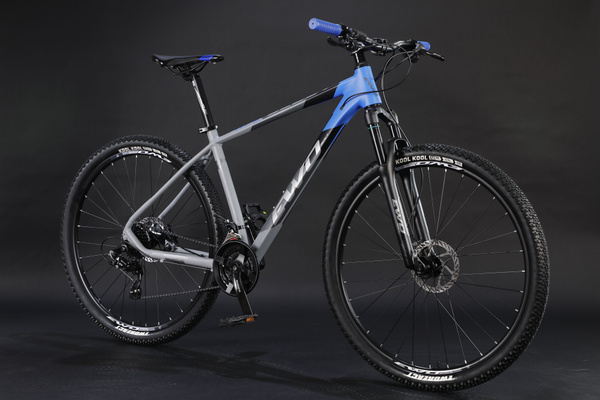

In [ ]:
# Исходное фото:
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1nualWOJcgWFExea8FyTnvqkl2lnkC5rv'
image_name = 'image3.jpg'
gdown.download(url, image_name)
path = '/content/' + image_name
image = cv2.imread(path)
cv2_imshow(image)

In [ ]:
# Загрузка модели YOLOv8 (специальный вариант для классификации)
model = YOLO('yolov8n-cls.pt')

In [ ]:
def process_image(img):
    # Обработка кадра с помощью модели
    results = model(img)[0]

    # Отображение результатов классификации на изображении
    if results.probs is not None:
        # Доступ к вершинам классификации
        top1_idx = results.probs.top1  # Индекс класса с наивысшей вероятностью
        top1_conf = results.probs.top1conf.item()  # Вероятность для класса с наивысшей вероятностью
        class_name = results.names[top1_idx]  # Получаем имя класса по индексу

        # Отображаем класс и вероятность на кадре
        label = f"{class_name}: {top1_conf:.2f}"
        cv2.putText(img, label, (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 0, 0), 3)

    return image

Посмотрим, что получилось:

In [ ]:
image = cv2.imread(path)
image = process_image(image)
cv2_imshow(image)

# Поиск ключевых точек тела - определения позы человека

Способов применения данной модели можно найти множество, вот некоторые из них:

*   **Тренировки спортсменов:** Помощь в анализе движений спортсменов для улучшения их техники
*   **Реабилитация:** Мониторинг и корректировка движений пациентов во время реабилитационных упражнений.
*   **Обнаружение падений:** Автоматическое обнаружение падений и других опасных ситуаций для пожилых людей или работников на производстве.
*   **Анимация:** Создание реалистичных движений для анимационных персонажей в фильмах и видеоиграх.

*   **Виртуальная и дополненная реальность:** Реалистичное отслеживание движений пользователей для создания интерактивных VR и AR приложений.

*   **Анализ поведения клиентов:** Изучение движения и поведения клиентов в магазинах для оптимизации выкладки товаров и улучшения обслуживания.

*   **Цифровые зеркала:** Виртуальная примерка одежды, позволяющая клиентам видеть, как они будут выглядеть в разных нарядах без необходимости физической примерки.



Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1vpQ9yj7WIghJ2rSNw8RXBkAdNgFpNwPM
To: /content/image4.jpg
100%|██████████| 776k/776k [00:00<00:00, 30.7MB/s]


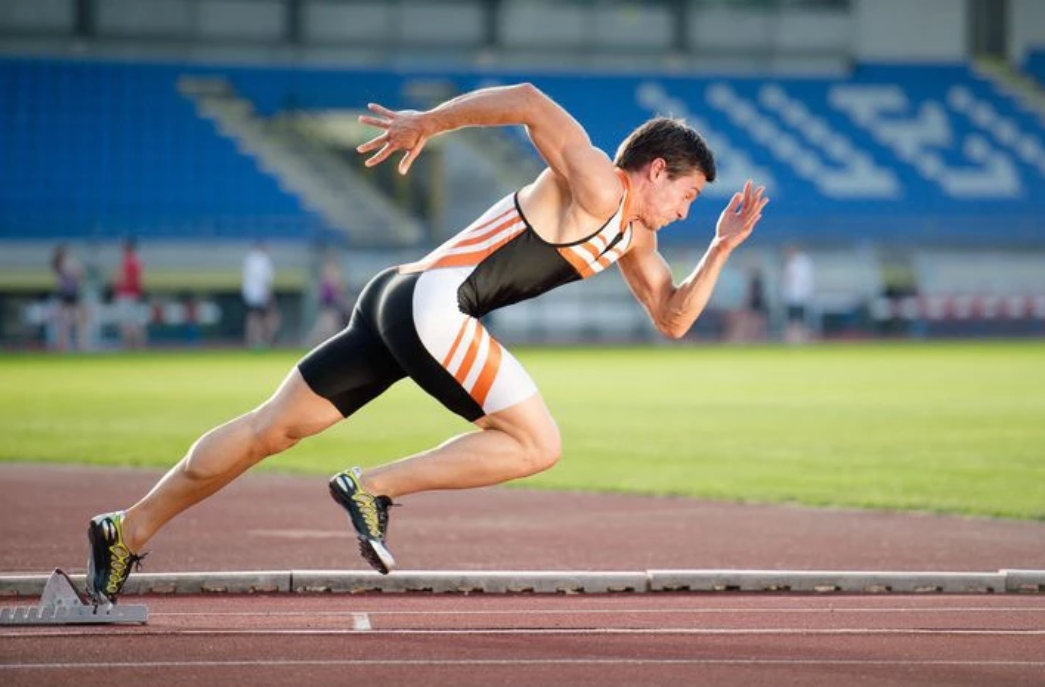

In [6]:
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1vpQ9yj7WIghJ2rSNw8RXBkAdNgFpNwPM'
image_name = 'image4.jpg'
gdown.download(url, image_name)
path = '/content/' + image_name
image = cv2.imread(path)
cv2_imshow(image)

In [8]:
# Загрузка модели YOLOv8-Pose
model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.52M/6.52M [00:00<00:00, 230MB/s]


In [9]:
# Словарь цветов для различных классов
colors = {
    'white': (255, 255, 255),
    'red': (0, 0, 255),
    'blue': (255, 0, 0)
}

In [10]:
def draw_skeleton(image, keypoints, confs, pairs, color):
    for (start, end) in pairs:
        if confs[start] > 0.5 and confs[end] > 0.5:
            x1, y1 = int(keypoints[start][0]), int(keypoints[start][1])
            x2, y2 = int(keypoints[end][0]), int(keypoints[end][1])
            if (x1, y1) != (0, 0) and (x2, y2) != (0, 0):  # Игнорирование точек в (0, 0)
                cv2.line(image, (x1, y1), (x2, y2), color, 2)

In [11]:
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    if image is None:
        print("Ошибка: не удалось загрузить изображение")
        return

    # Обработка изображения с помощью модели
    results = model(image)[0]

    # Проверка на наличие обнаруженных объектов
    if hasattr(results, 'boxes') and hasattr(results.boxes, 'cls') and len(results.boxes.cls) > 0:
        classes_names = results.names
        classes = results.boxes.cls.cpu().numpy()
        boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)

        # Обработка ключевых точек
        if results.keypoints:
            keypoints = results.keypoints.data.cpu().numpy()
            confs = results.keypoints.conf.cpu().numpy()

            for i, (class_id, box, kp, conf) in enumerate(zip(classes, boxes, keypoints, confs)):
                draw_box=False
                if draw_box:
                    class_name = classes_names[int(class_id)]
                    color = colors['white']
                    x1, y1, x2, y2 = box
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Визуализация ключевых точек с номерами
                for j, (point, point_conf) in enumerate(zip(kp, conf)):
                    if point_conf > 0.5:  # Фильтрация по уверенности
                        x, y = int(point[0]), int(point[1])
                        if (x, y) != (0, 0):  # Игнорирование точек в (0, 0)
                            cv2.circle(image, (x, y), 5, colors['blue'], -1)
                            cv2.putText(image, str(j), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors['blue'], 2)

                # Рисование скелета
                draw_skeleton(image, kp, conf, [(5, 7), (7, 9), (6, 8), (8, 10)], colors['white']) # Руки
                draw_skeleton(image, kp, conf, [(11, 13), (13, 15), (12, 14), (14, 16)], colors['red']) # Ноги
                draw_skeleton(image, kp, conf, [(5, 11), (6, 12)], colors['blue']) # Тело

    # Сохранение и отображение результатов
    output_path = os.path.splitext(image_path)[0] + "_pose_detected.jpg"
    cv2.imwrite(output_path, image)
    print(f"Сохранено изображение с результатами: {output_path}")


In [ ]:
image_path = '/content/image4.jpg'
process_image(image_path)

Посмотрим, что получилось:

In [ ]:
image = cv2.imread('/content/image4_pose_detected.jpg')
cv2_imshow(image)

# На этом мы пожалуй закончим с YOLO. Желающие продолжить эксперименты могут самостоятельно проделать их по статье: https://habr.com/ru/articles/821971/